## Problem Statement
In preparation for applying to a new data science job in six months, we aim to enhance our resume by identifying potentially missing data science skills. To achieve this, we will analyze job postings from a popular job-search website, comparing them with the content of our resume and the table of contents of a relevant book. Our approach involves parsing text from downloaded HTML files, exploring how job skills are commonly described, filtering out irrelevant postings, clustering job skills, and finally, updating our resume with any identified missing skills.

In [2]:
# import libraries
import glob
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs

In [3]:
html_contents = []
for filename in sorted(glob.glob('job_postings/*.html')):
    with open(filename, 'r') as f:
        html_contents.append(f.read())

print(f"We have loaded {len(html_contents)} HTML files.")

We have loaded 1458 HTML files.


In [4]:
soup_objects = []
for html in html_contents:
    soup = bs(html)
    assert soup.title is not None
    assert soup.body is not None
    soup_objects.append(soup)

In [5]:
html_dict = {'Title': [], 'Body': []}

for soup in soup_objects:
    title = soup.find('title').text
    body = soup.find('body').text
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)

df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
summary

,Title,Body
count,1458,1458
unique,1364,1458
top,"Data Scientist - New York, NY","Data Scientist - Beavercreek, OH\nData Scienti..."
freq,13,1


### Explore the HTML for skills descriptions

In [6]:
from IPython.core.display import display, HTML
display(HTML(html_contents[0]))

In [7]:
display(HTML(html_contents[1]))

In [8]:
df_jobs['Bullets'] = [[bullet.text.strip() for bullet in soup.find_all('li')]
                      for soup in soup_objects]

In [9]:
df_jobs.head()

,Title,Body,Bullets
0,"Data Scientist - Beavercreek, OH","Data Scientist - Beavercreek, OH\nData Scienti...",[Use statistical research methods to analyze d...
1,"Data Scientist - Seattle, WA 98101","Data Scientist - Seattle, WA 98101\nAre you in...",[Interface with our internal engagement teams ...
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[Design, develop, document and maintain machin..."
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...
4,"Data Manager / Analyst - Oakland, CA","Data Manager / Analyst - Oakland, CA\nHOW YOU ...",[You possess excellent communication and relat...


In [10]:
df_jobs.shape

(1458, 3)

In [11]:
df_jobs.Bullets[0]

['Use statistical research methods to analyze datasets produced through multiple sources of intelligence production',
 'Mine and analyze data from databases to answer key intelligence questions',
 'Assess the effectiveness and accuracy of new data sources and data gathering techniques',
 'Develop custom data models and algorithms to apply to data sets',
 'Use predictive modeling to produce reporting about future trends based on historical data',
 'Spatially analyze geographic data using GIS tools',
 'Visualize findings in easily understood graphics and aesthetically appealing finished reports',
 'Experience using statistical computer languages (R, Python, SLQ, etc.) to manipulate data and draw insights from large data sets',
 'Experience in basic visualization methods, especially using tools such as Tableau, ggplot, and matplotlib',
 'Knowledge of a variety of machine learning techniques (clustering, decision tree learning, artificial neural networks, etc.) and their real-world advanta

In [12]:
non_bulleted_posts = []
bulleted_post_count = 0
for i, bullet_list in enumerate(df_jobs.Bullets):
    if bullet_list:
        bulleted_post_count += 1
    else:
        non_bulleted_posts.append((i, df_jobs.iloc[i]))

percent_bulleted = 100.0 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullets")

90.53% of the postings contain bullets


In [13]:
# display a non-bulleted post
display(HTML(html_contents[non_bulleted_posts[5][0]]))

#### Do all (or most) of these bullets focus on skills?

In [14]:
# Examine the top-ranked words in the HTML bullets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
    df = pd.DataFrame({'Words': vectorizer.get_feature_names_out(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df


all_bullets = []
for bullet_list in df_jobs.Bullets:
    all_bullets.extend(bullet_list)

sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
experience    878.030398
      data    842.978780
    skills    440.780236
      work    371.684232
   ability    370.969638


In [15]:
non_bullets = []
for soup in soup_objects:
    body = soup.body
    for tag in body.find_all('li'):
        tag.decompose()

    non_bullets.append(body.text)

sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data     99.111312
      team     39.175041
      work     38.928948
experience     36.820836
  business     36.140488


In [16]:
regex = r'Data Scien(ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]

percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f"{percent_non_ds:.2f}% of the job posting titles do not mention a "
 "data science position. Below is a sample of such titles:\n")

for title in df_non_ds_jobs.Title[:10]:
    print(title)

64.33% of the job posting titles do not mention a data science position. Below is a sample of such titles:

Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL
Data Manager / Analyst - Oakland, CA
Scientific Programmer - Berkeley, CA
JD Digits - AI Lab Research Intern - Mountain View, CA
Operations and Technology Summer 2020 Internship-West Coast - Universal City, CA
Data and Reporting Analyst - Olympia, WA 98501
Senior Manager Advanced Analytics - Walmart Media Group - San Bruno, CA
Data Specialist, Product Support Operations - Sunnyvale, CA
Deep Learning Engineer - Westlake, TX
Research Intern, 2020 - San Francisco, CA 94105


<ipython-input-16-948a13d314f4>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]


In [17]:
df_non_ds_jobs.Bullets.iloc[0]

['Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse',
 'Accurately documents care provided',
 'Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning',
 'Participates in economical utilization of supplies and ensures that equipment and nursing units are maintained in a clean, safe manner',
 'Routinely follows and adheres to all policies and procedures',
 'Assists in performance improvement (PI) activities by serving on PI teams as warranted, assisting with PI measures and supporting and implementing changes necessary for improvement',
 'Maintains performance, patient and employee satisfaction and financial standards as outlined in the performance evaluation',
 'Performs compliance requirements as outlined in the Employee Handbook',
 'Must adhere to

### Filter job postings by relevance

In [18]:
resume = open('resume.txt', 'r').read()
print(resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


In [19]:
table_of_contents = open('table_of_contents.txt', 'r').read()

In [20]:
existing_skills = resume + table_of_contents

In [21]:
text_list = df_jobs.Body.values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()

In [22]:
cosine_similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]
df_jobs['Relevance'] = cosine_similarities
sorted_df_jobs = df_jobs.sort_values('Relevance', ascending=False)

for title in sorted_df_jobs[-20:].Title:
    print(title)

Data Analyst Internship (8 month minimum) - San Francisco, CA
Leadership and Advocacy Coordinator - Oakland, CA 94607
Finance Consultant - Audi Palo Alto - Palo Alto, CA
RN - Hattiesburg, MS
Configuration Management Specialist - Dahlgren, VA
Deal Desk Analyst - Mountain View, CA
Dev Ops Engineer AWS - Rockville, MD
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Berkeley, CA
Scorekeeper - Oakland, CA 94612
Direct Care - All Experience Levels (CNA, HHA, PCA Welcome) - Norwell, MA 02061
Director of Marketing - Cambridge, MA
Certified Strength and Conditioning Specialist - United States
PCA - PCU Full Time - Festus, MO 63028
Performance Improvement Consultant - Los Angeles, CA
Patient Services Rep II - Oakland, CA
Lab Researcher I - Richmond, CA
Part-time instructor of Statistics for Data Science and Machine Learning - San Francisco, CA 94105
Plant Engineering Specialist - San Pablo, CA
Page Not Found - Indeed Mobile
Director of Econometric Modeling - External Careers


In [23]:
for title in sorted_df_jobs.Title[:20]:
    print(title)

Chief Data Officer - Culver City, CA 90230
Data Scientist - Beavercreek, OH
Data Scientist Population Health - Los Angeles, CA 90059
Data Scientist - San Diego, CA
Data Scientist - Beavercreek, OH
Senior Data Scientist - New York, NY 10018
Data Architect - Raleigh, NC 27609
Data Scientist (PhD) - Spring, TX
Data Science Analyst - Chicago, IL 60612
Associate Data Scientist (BS / MS) - Spring, TX
Data Scientist - Streetsboro, OH 44241
Data Scientist - Los Angeles, CA
Sr Director of Data Science - Elkridge, MD
2019-57 Sr. Data Scientist - Reston, VA 20191
Data Scientist (PhD) - Intern - Spring, TX
Sr Data Scientist. - Alpharetta, GA 30004
Data Scientist GS 13/14 - Clarksburg, WV 26301
Data Science Intern (BS / MS) - Intern - Spring, TX
Senior Data Scientist - New York, NY 10038
Data Scientist - United States


In [24]:
sorted_df_jobs.iloc[0].Body

'Chief Data Officer - Culver City, CA 90230\nMetro-Goldwyn-Mayer Studios Inc. ("MGM") is seeking a Chief Data Officer who will support our product, sales, leadership and marketing teams with insights gained from analyzing data. The ideal candidate is adept at using large data sets to find opportunities for product and process optimization and using models to test the effectiveness of different courses of action. They must have strong experience using a variety of data mining/data analysis methods, using a variety of data tools, building and implementing models, using/creating algorithms and creating/running simulations. They must have a proven ability to drive business results with their data-based insights. They must be comfortable working with a wide range of stakeholders and functional teams. The right candidate will have a passion for discovering solutions hidden in large data sets and working with stakeholders to improve business outcomes.\n\nResponsibilities:\n\nWork with stakeho

In [25]:
df_jobs.head()

,Title,Body,Bullets,Relevance
0,"Data Scientist - Beavercreek, OH","Data Scientist - Beavercreek, OH\nData Scienti...",[Use statistical research methods to analyze d...,0.135825
1,"Data Scientist - Seattle, WA 98101","Data Scientist - Seattle, WA 98101\nAre you in...",[Interface with our internal engagement teams ...,0.049226
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[Design, develop, document and maintain machin...",0.040723
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...,0.012620
4,"Data Manager / Analyst - Oakland, CA","Data Manager / Analyst - Oakland, CA\nHOW YOU ...",[You possess excellent communication and relat...,0.015471


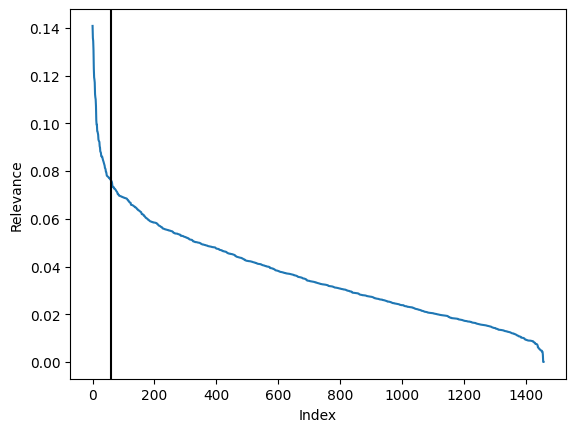

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(sorted_df_jobs.shape[0]), sorted_df_jobs.Relevance)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

In [27]:
for title in sorted_df_jobs[40:60].Title.values:
    print(title)

Data Scientist III - Pasadena, CA 91101
Global Data Engineer - Boston, MA
Data Analyst and Data Scientist - Summit, NJ
Data Scientist - Generalist - Glendale, CA
Data Scientist - Seattle, WA
IT Data Scientist - Contract - Riverton, UT
Data Scientist (Analytic Consultant 4) - San Francisco, CA
Data Scientist - Seattle, WA
Data Science & Tagging Analyst - Bethesda, MD 20814
Data Scientist - New York, NY
Senior Data Scientist - Los Angeles, CA
Principal Statistician - Los Angeles, CA
Senior Data Analyst - Los Angeles, CA
Data Scientist - Aliso Viejo, CA 92656
Data Engineer - Seattle, WA
Data Scientist - Digital Factory - Tampa, FL 33607
Data Scientist - Grapevine, TX 76051
Data Scientist - Bioinformatics - Denver, CO 80221
EPIDEMIOLOGIST - Los Angeles, CA
Data Scientist - Bellevue, WA


In [28]:
for title in sorted_df_jobs[60:80].Title.values:
    print(title)

Data Scientist - Aliso Viejo, CA
Data Scientist and Visualization Specialist - Santa Clara Valley, CA 95014
Data Scientist - Los Angeles, CA
Data Scientist Manager - NEW YORK LOCATION! - New York, NY 10036
Data Science Intern - San Francisco, CA 94105
Research Data Analyst - San Francisco, CA
Sr Data Scientist (Analytic Consultant 5) - San Francisco, CA
Data Scientist, Media Manipulation - Cambridge, MA
Manager, Data Science, Programming and Visualization - Boston, MA
Data Scientist in Broomfield, CO - Broomfield, CO
Senior Data Scientist - Executive Projects and New Solutions - Foster City, CA
Manager of Data Science - Burbank California - Burbank, CA
Data Scientist Manager - Hiring in Burbank! - Burbank, CA
Data Scientists needed in NY - Senior Consultants and Managers! - New York, NY 10036
Data Scientist - Menlo Park, CA
Data Engineer - Santa Clara, CA
Data Scientist - Remote
Data Scientist I-III - Phoenix, AZ 85021
SWE Data Scientist - Santa Clara Valley, CA 95014
Health Science Sp

In [29]:
import re

def percent_relevant_titles(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)', flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)', flags=re.IGNORECASE)

    match_count = len([title for title in df.Title
                       if regex_relevant.search(title)
                       and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent


percent = percent_relevant_titles(sorted_df_jobs[60: 80])
print(f"Approximately {percent:.2f}% of job titles between indices "
 "60 - 80 are relevant")

Approximately 65.00% of job titles between indices 60 - 80 are relevant


In [30]:
percent = percent_relevant_titles(sorted_df_jobs[80: 100])
print(f"Approximately {percent:.2f}% of job titles between indices "
        "80 - 100 are relevant")

Approximately 80.00% of job titles between indices 80 - 100 are relevant


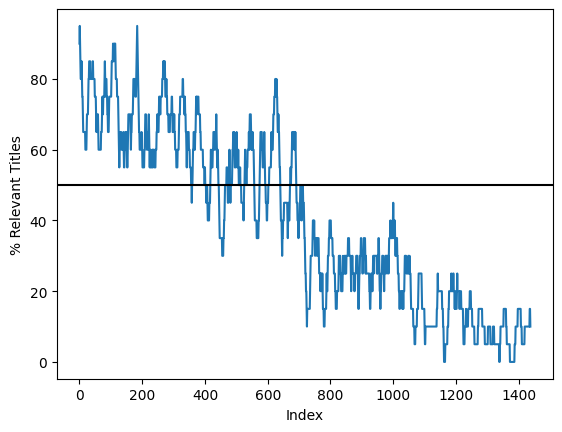

In [31]:
def relevant_title_plot(index_range=20):
    percentages = []
    start_indices = range(df_jobs.shape[0] - index_range)
    for i in start_indices:
        df_slice = sorted_df_jobs[i: i + index_range]
        percent = percent_relevant_titles(df_slice)
        percentages.append(percent)

    plt.plot(start_indices, percentages)
    plt.axhline(50, c='k')
    plt.xlabel('Index')
    plt.ylabel('% Relevant Titles')


relevant_title_plot()
plt.show()

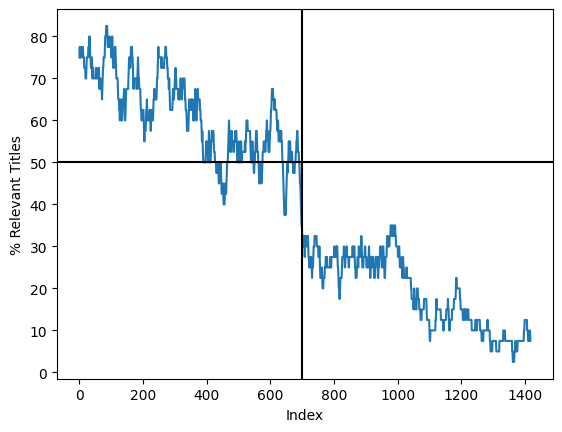

In [32]:
relevant_title_plot(index_range=40)
plt.axvline(700, c='k')
plt.show()

### Cluster skills in job postings (cutoff - 60)

In [33]:
total_bullets = []
for bullets in sorted_df_jobs[:60].Bullets:
    total_bullets.extend(bullets)

In [34]:
df_bullets = pd.DataFrame({'Bullet': total_bullets})
df_bullets.describe()

,Bullet
count,1091
unique,900
top,Knowledge of advanced statistical techniques a...
freq,9


In [35]:
total_bullets = sorted(set(total_bullets))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(total_bullets)
num_rows, num_columns = tfidf_matrix.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")

Our matrix has 900 rows and 2070 columns


In [36]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
np.random.seed(0)

def shrink_matrix(tfidf_matrix):
    svd_object = TruncatedSVD(n_components=100)
    shrunk_matrix = svd_object.fit_transform(tfidf_matrix)
    return normalize(shrunk_matrix)


shrunk_norm_matrix = shrink_matrix(tfidf_matrix)

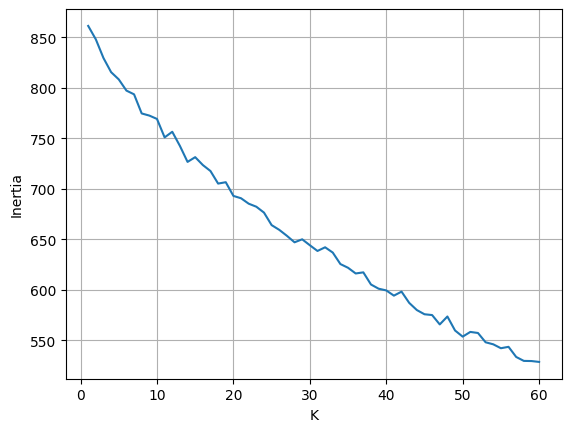

In [37]:
np.random.seed(0)
from sklearn.cluster import MiniBatchKMeans

def generate_elbow_plot(matrix):
    k_values = range(1, 61)
    inertia_values = [MiniBatchKMeans(k, n_init='auto').fit(matrix).inertia_
                      for k in k_values]
    plt.plot(k_values, inertia_values)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


generate_elbow_plot(shrunk_norm_matrix)

#### Group the job skills into 15 clusters

In [38]:
np.random.seed(0)
from sklearn.cluster import KMeans

def compute_cluster_groups(shrunk_norm_matrix, k=15,
                           bullets=total_bullets):
    cluster_model = KMeans(n_clusters=k, n_init='auto')
    clusters = cluster_model.fit_predict(shrunk_norm_matrix)
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': bullets})
    return [df_cluster for _, df_cluster in df.groupby('Cluster')]


cluster_groups = compute_cluster_groups(shrunk_norm_matrix)

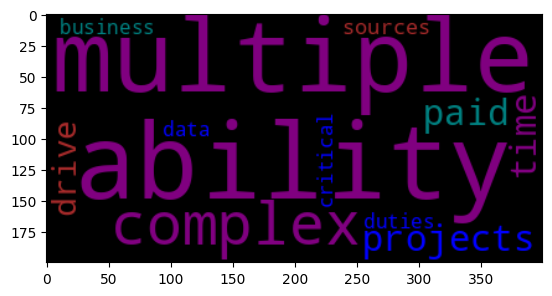

In [39]:
from wordcloud import WordCloud
np.random.seed(0)

def cluster_to_image(df_cluster, max_words=15, tfidf_matrix=tfidf_matrix,
                     vectorizer=vectorizer):
    indices = df_cluster.Index.values
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': vectorizer.get_feature_names_out(),
            'Summed TFIDF': summed_tfidf}
    df_ranked_words = pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)

    words_to_score = {word: score
                      for word, score in df_ranked_words[:max_words].values
                      if score != 0}
    cloud_generator = WordCloud(color_func=_color_func)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return wordcloud_image


def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])


wordcloud_image = cluster_to_image(cluster_groups[0])
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.show()

In [40]:
np.random.seed(1)
def print_cluster_sample(cluster_id):
    df_cluster = cluster_groups[cluster_id]
    for bullet in np.random.choice(df_cluster.Bullet.values, 5, replace=False):
        print(bullet)


print_cluster_sample(0)

Ability to quickly translate business requirements, questions, investigations into a set of queries
Resume
Mentor complex projects using wide breadth of data sciences and advanced techniques
Outstanding leadership and managerial capabilities, including the ability to effectively direct tasking, and assess and manage performance
Knowledge of word embedding concepts like word2vec and TF-IDF


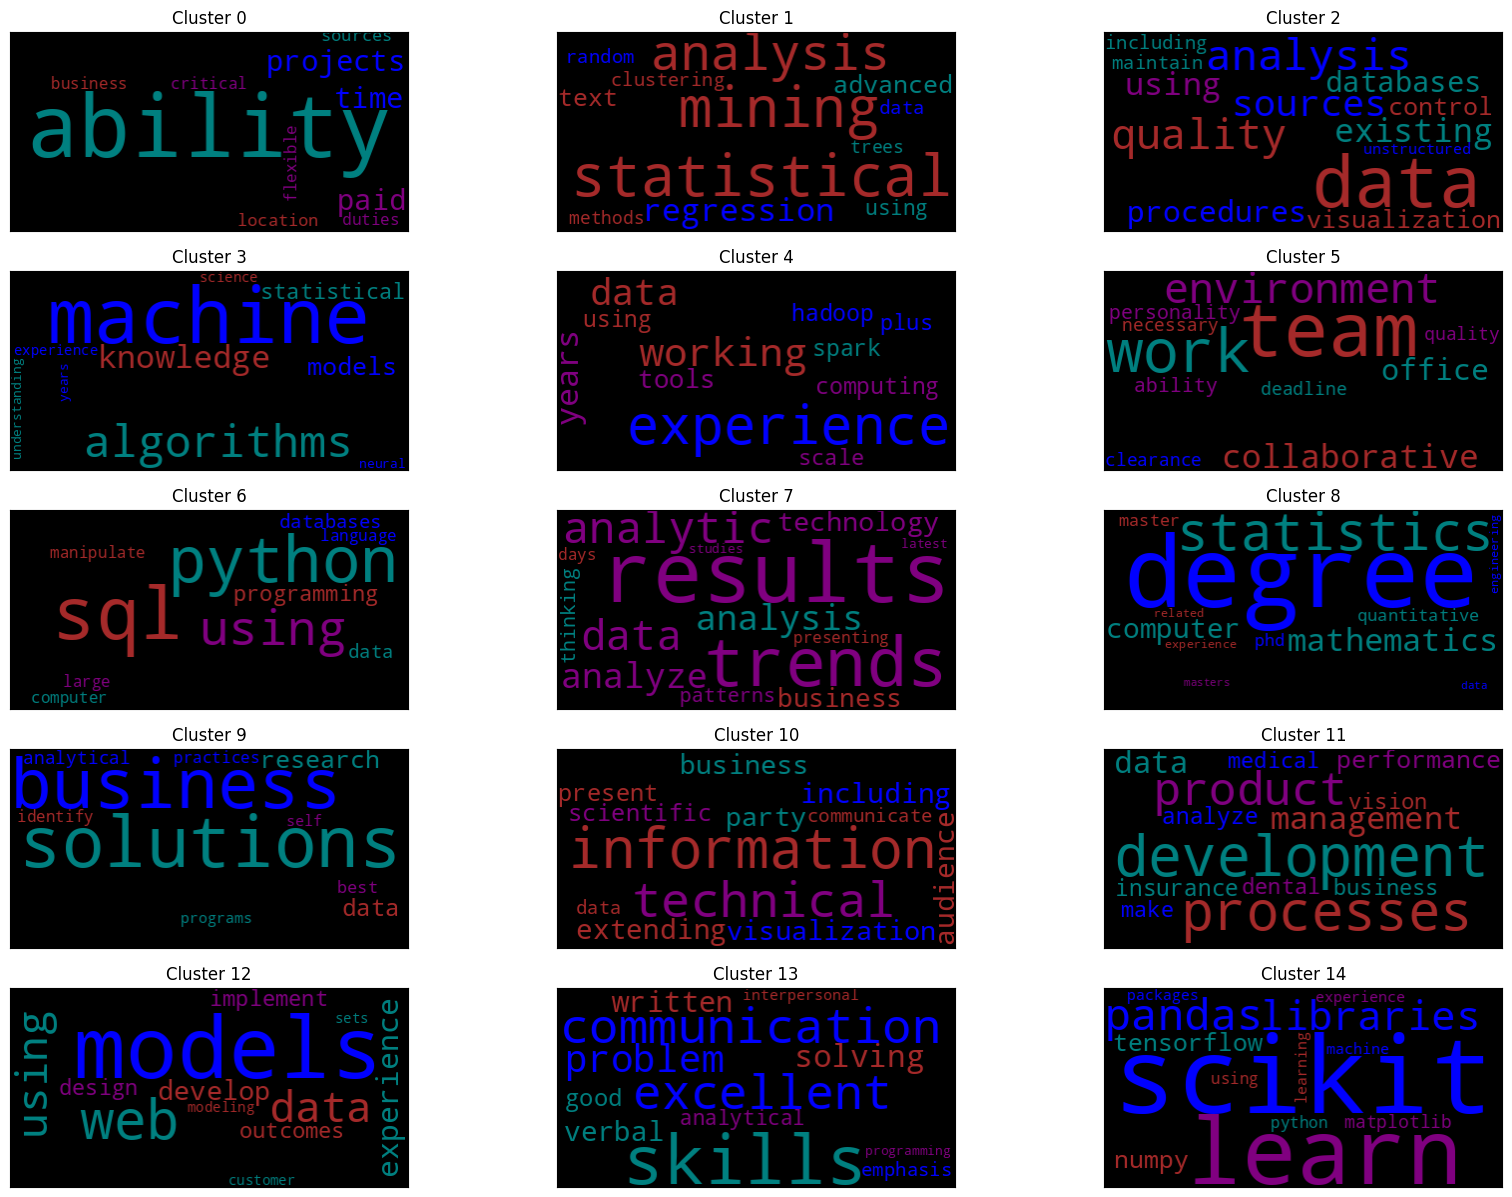

In [41]:
def plot_wordcloud_grid(cluster_groups, num_rows=5, num_cols=3, **kwargs):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    cluster_groups_copy = cluster_groups[:]
    for r in range(num_rows):
        for c in range(num_cols):
            if not cluster_groups_copy:
                break

            df_cluster = cluster_groups_copy.pop(0)
            wordcloud_image = cluster_to_image(df_cluster, **kwargs)
            ax = axes[r][c]
            ax.imshow(wordcloud_image, interpolation='bilinear')
            ax.set_title(f'Cluster {df_cluster.Cluster.iloc[0]}')
            ax.set_xticks([])
            ax.set_yticks([])

plot_wordcloud_grid(cluster_groups)
plt.show()

In [42]:
print_cluster_sample(6)

Strong programming skills using advanced tools like Python, SAS, PySpark, H2O, Hive, Scala or SQL with ability to write efficient code to manipulate data for analytical purposes, conduct statistical analysis, and develop predictive models. Ability to learn new technologies quickly
Experience in Python, Scala, Java, C, C++ or R is required
Experience using statistical computer languages (R, Java, Python, SQL, etc.) to manipulate data and draw insights from large data sets
Employ a variety of languages and tools (e.g. scripting languages) to integrate data from different systems
Programming using Python, R, SQL


In [43]:
# Computing similarities between the bullets and our resume
def compute_bullet_similarity(bullet_texts):
    bullet_vectorizer = TfidfVectorizer(stop_words='english')
    matrix = bullet_vectorizer.fit_transform(bullet_texts + [resume]).toarray()
    return matrix[:-1] @ matrix[-1]


bullet_cosine_similarities = compute_bullet_similarity(total_bullets)

In [44]:
def compute_mean_similarity(df_cluster):
    indices = df_cluster.Index.values
    return bullet_cosine_similarities[indices].mean()


tech_mean = compute_mean_similarity(cluster_groups[14])
soft_mean = compute_mean_similarity(cluster_groups[13])
print(f"Technical cluster 14 has a mean similarity of {tech_mean:.3f}")
print(f"Soft-skill cluster 13 has a mean similarity of {soft_mean:.3f}")

Technical cluster 14 has a mean similarity of 0.204
Soft-skill cluster 13 has a mean similarity of 0.024


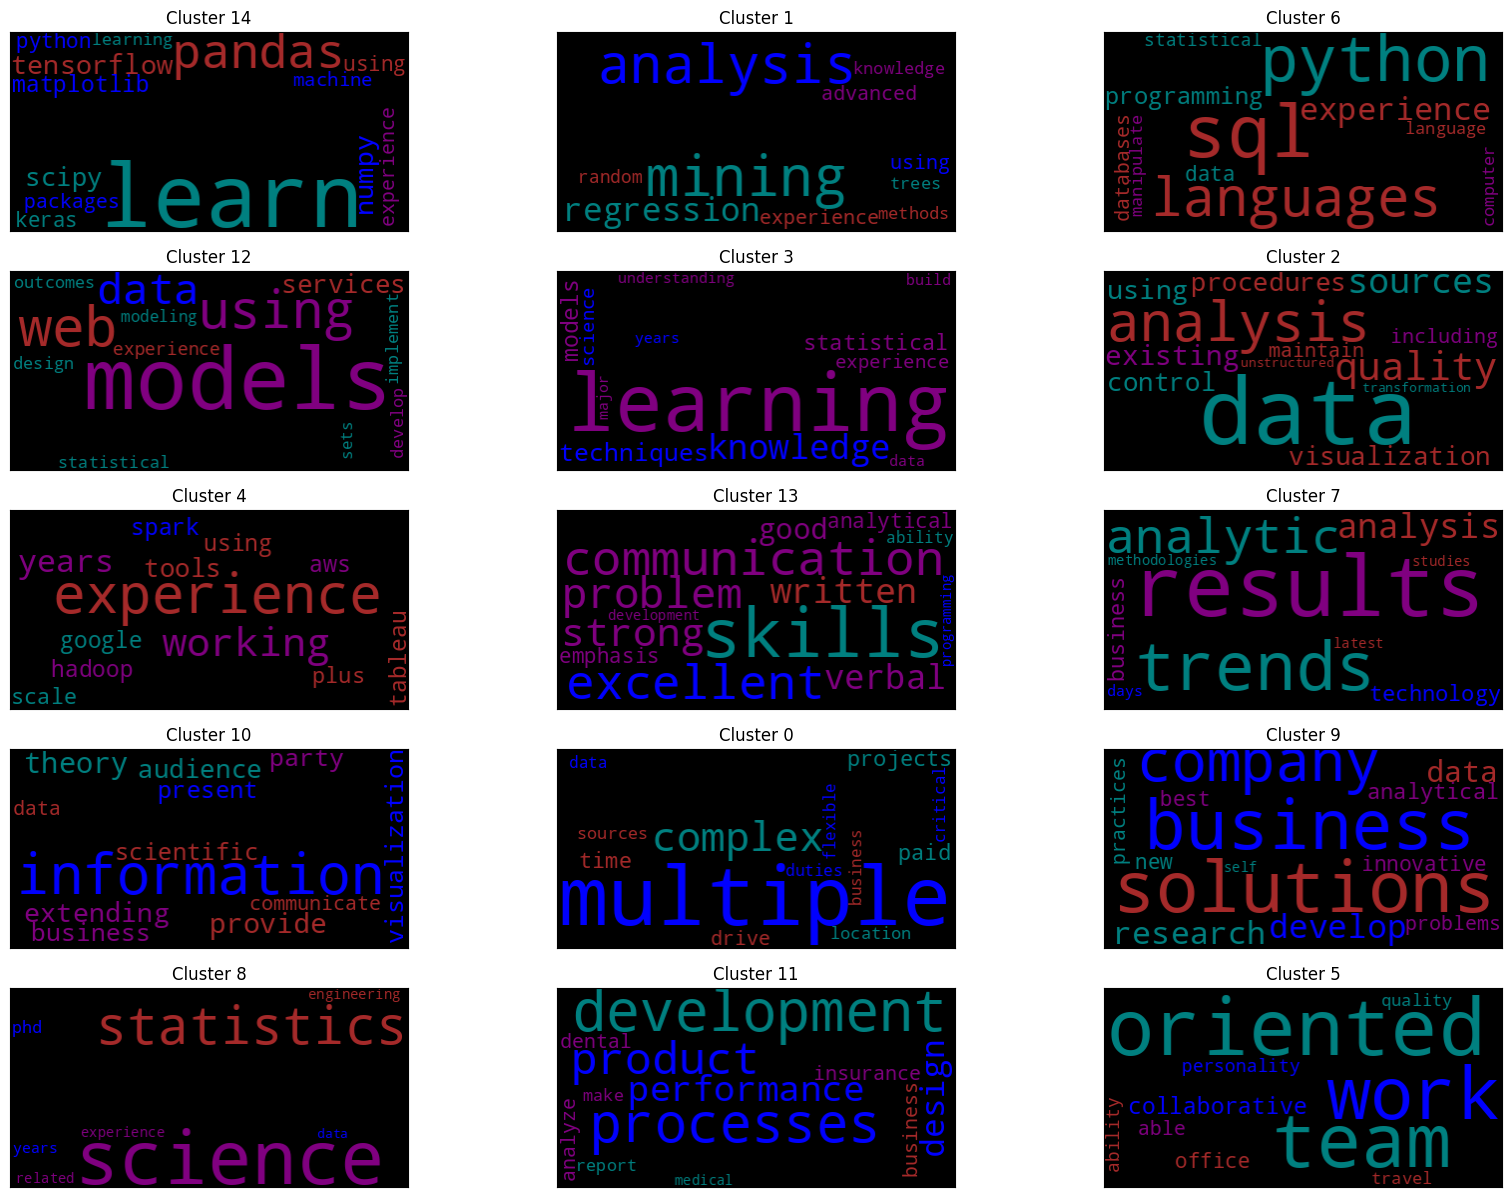

In [45]:
def sort_cluster_groups(cluster_groups):
    mean_similarities = [compute_mean_similarity(cluster)
                        for cluster in cluster_groups]

    sorted_indices = sorted(range(len(cluster_groups)),
                            key=lambda i: mean_similarities[i],
                            reverse=True)
    return [cluster_groups[i] for i in sorted_indices]


sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups)
plt.show()

#### Group the job skills into 25 clusters

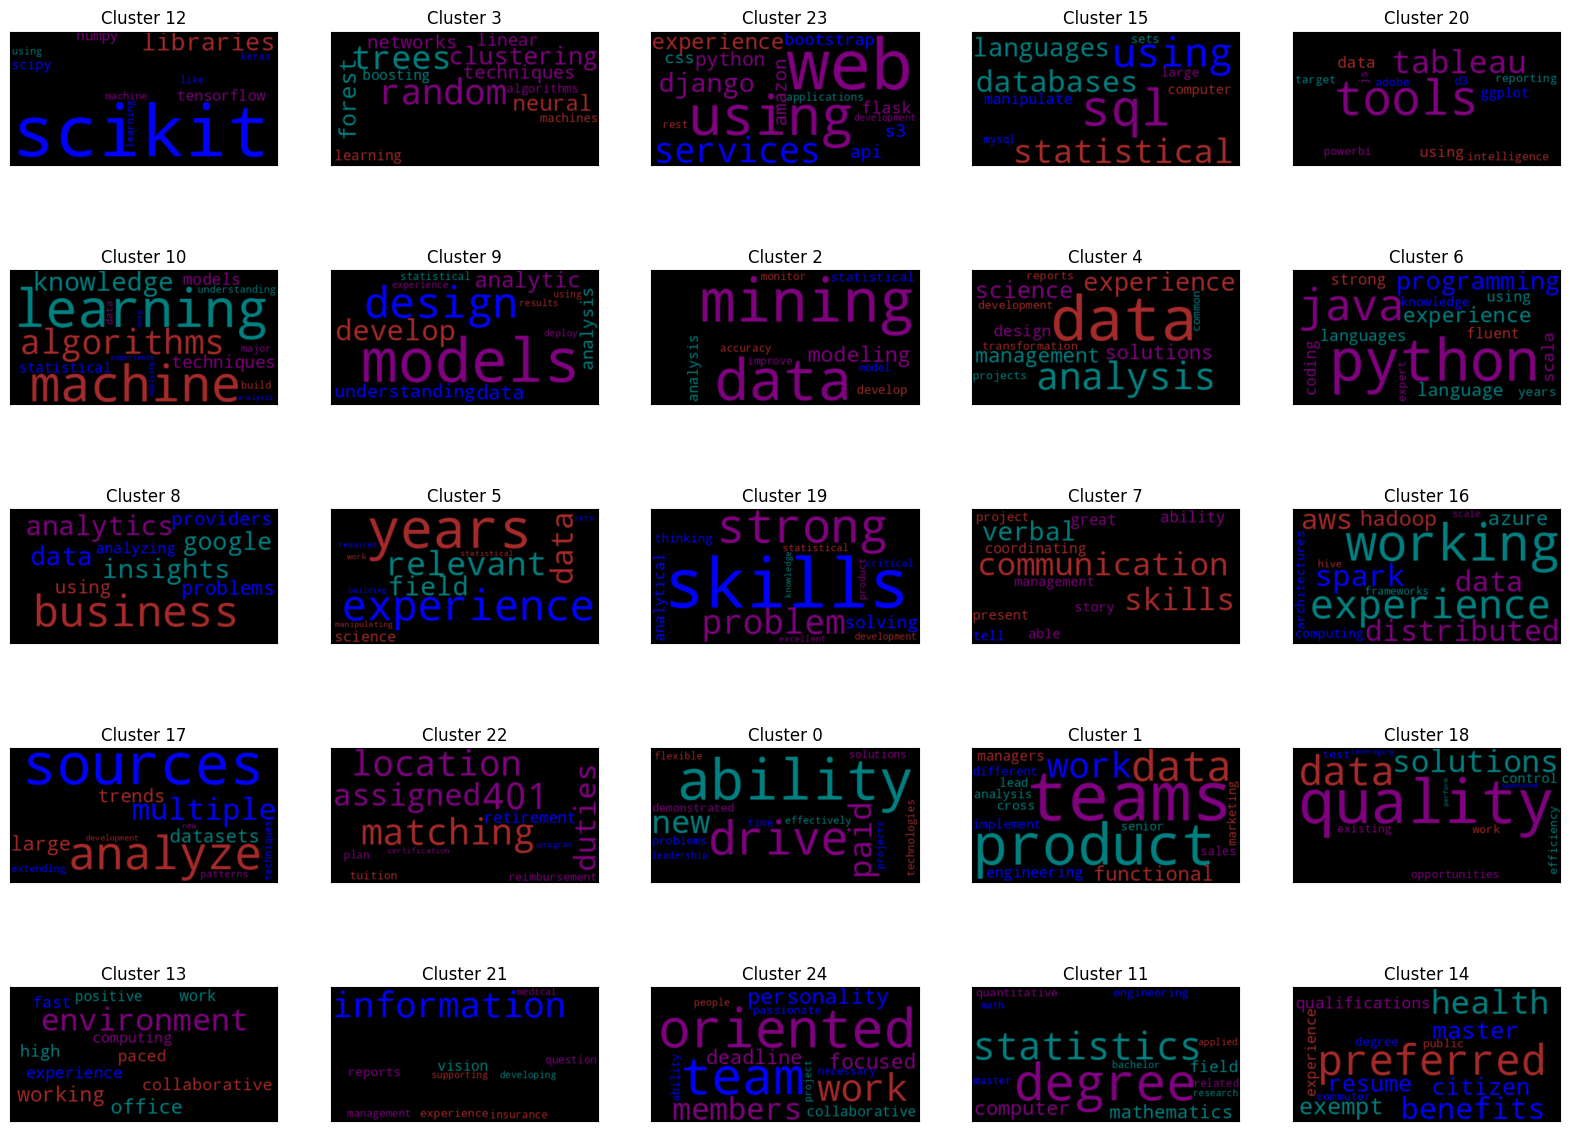

In [46]:
# k = 25
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=25)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_cols=5)
plt.show()

#### Group the job skills into 20 clusters

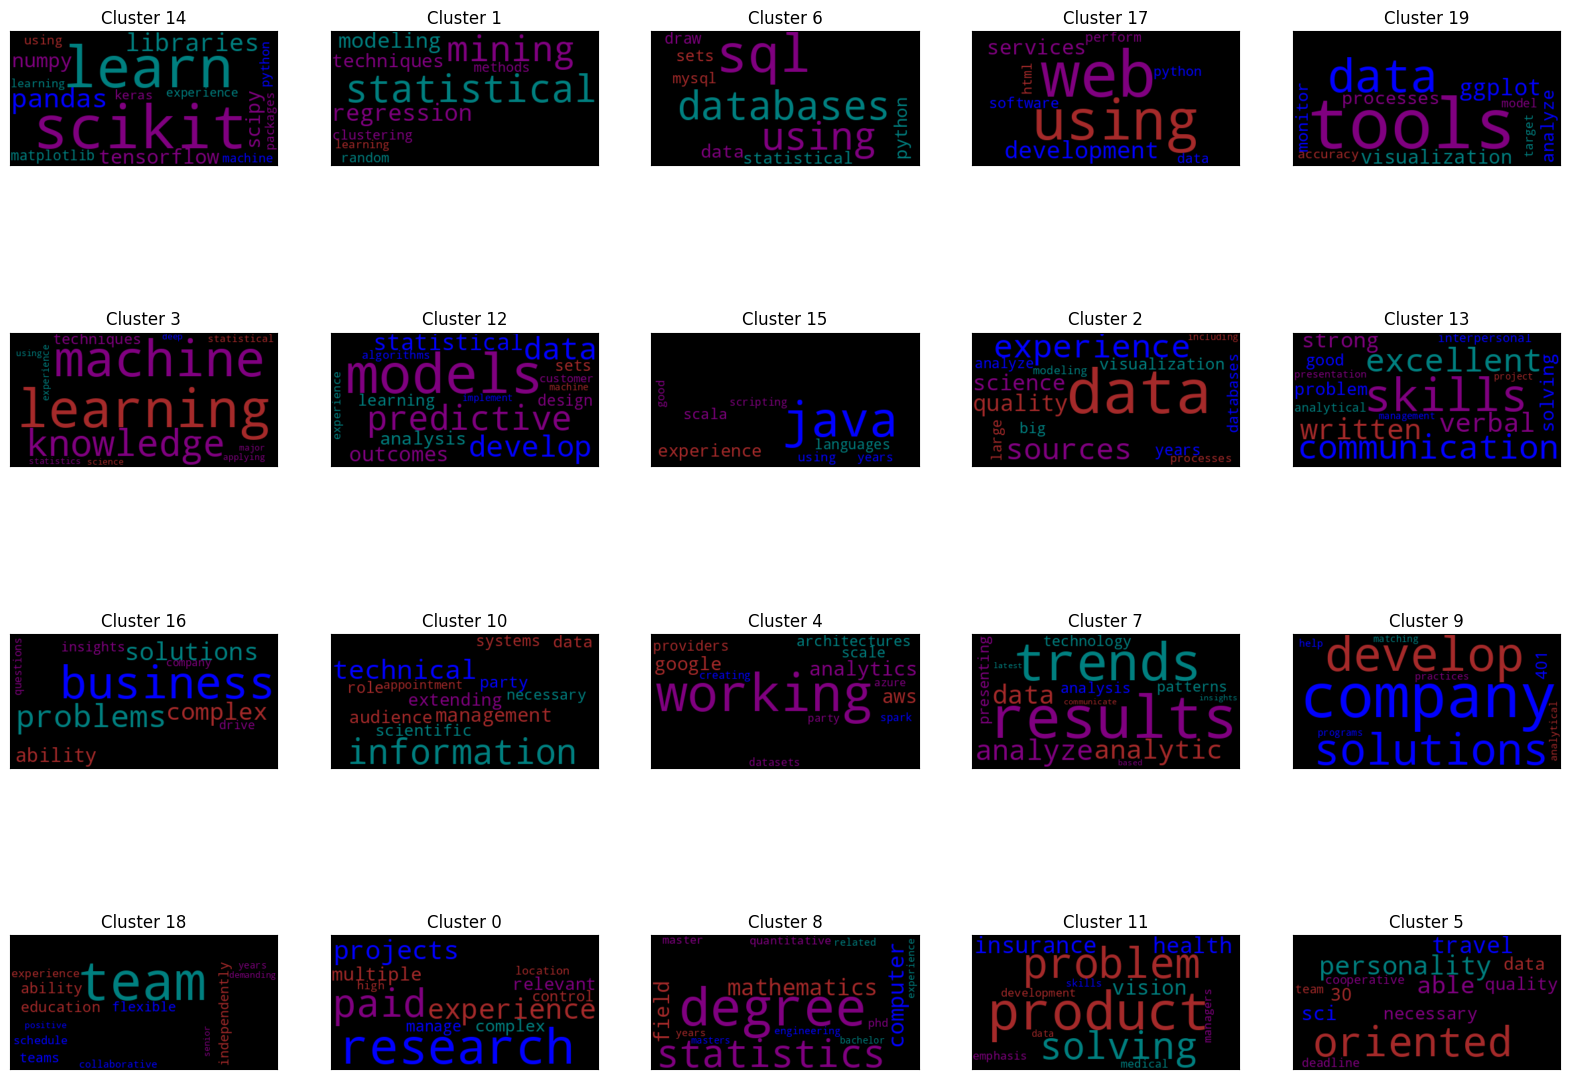

In [47]:
# k = 20
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=20)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=4, num_cols=5)
plt.show()

### Cluster skills in job postings (cutoff = 700)

In [48]:
np.random.seed(0)
total_bullets_700 = set()

for bullets in sorted_df_jobs[:700].Bullets:
    total_bullets_700.update([bullet.strip()
                            for bullet in bullets])

total_bullets_700 = sorted(total_bullets_700)
vectorizer_700 = TfidfVectorizer(stop_words='english')
tfidf_matrix_700 = vectorizer_700.fit_transform(total_bullets_700)
shrunk_norm_matrix_700 = shrink_matrix(tfidf_matrix_700)
print(f"We've vectorized {shrunk_norm_matrix_700.shape[0]} bullets")

We've vectorized 10194 bullets


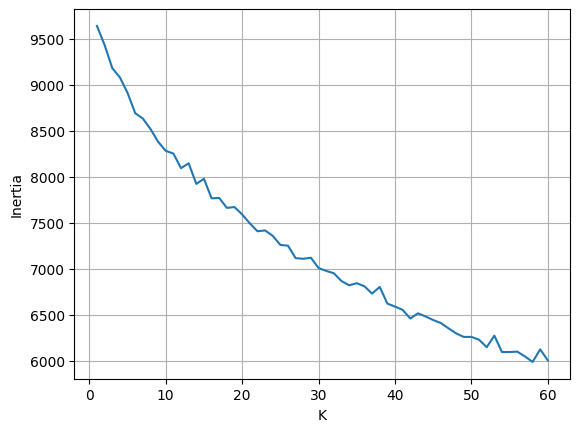

In [49]:
np.random.seed(0)
generate_elbow_plot(shrunk_norm_matrix_700)
plt.show()

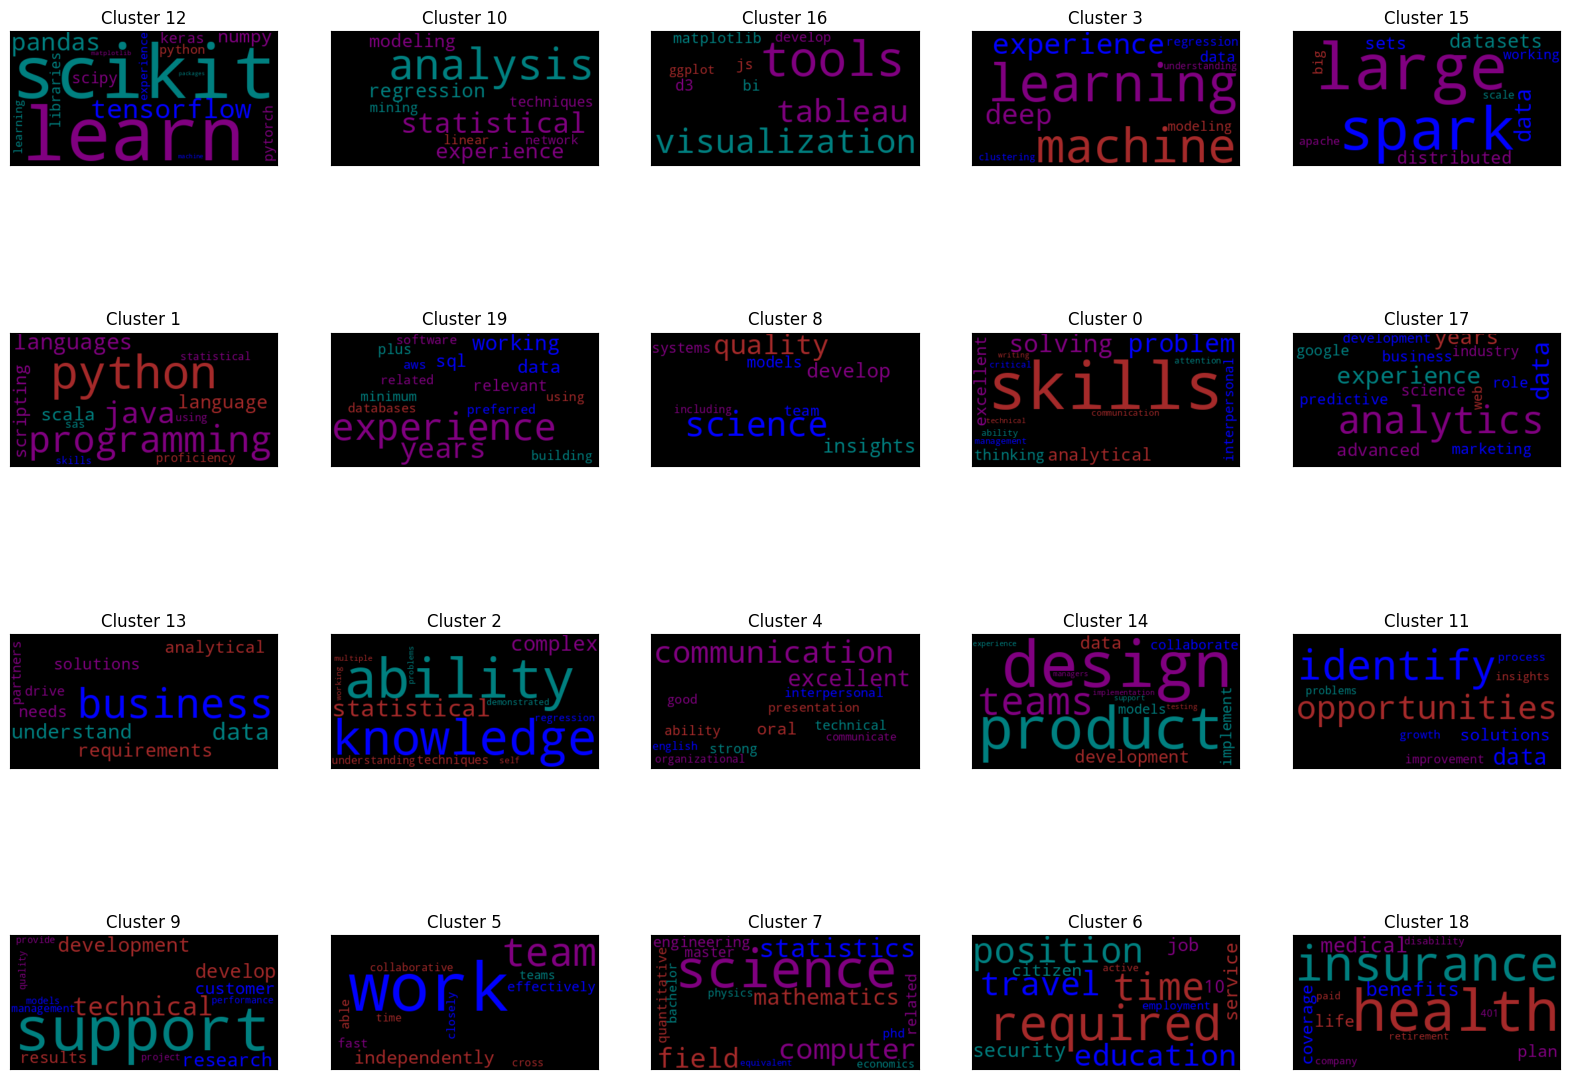

In [53]:
np.random.seed(0)
cluster_groups_700 = compute_cluster_groups(shrunk_norm_matrix_700, k=20,
                                            bullets=total_bullets_700)
bullet_cosine_similarities = compute_bullet_similarity(total_bullets_700)
sorted_cluster_groups_700 = sort_cluster_groups(cluster_groups_700)
plot_wordcloud_grid(sorted_cluster_groups_700, num_rows=4, num_cols=5,
                    vectorizer=vectorizer_700,
                    tfidf_matrix=tfidf_matrix_700)